In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
#plt.rcParams["font.size"] = "9"

In [3]:
vizwiz_train = pd.read_csv('../../data/three_vote_threshold/vizwiz_skill_typ_train.csv', skipinitialspace=True, engine='python')
vizwiz_val = pd.read_csv('../../data/three_vote_threshold/vizwiz_skill_typ_val.csv', skipinitialspace=True, engine='python')
vizwiz_test = pd.read_csv('../../data/three_vote_threshold/vizwiz_skill_typ_test.csv', skipinitialspace=True, engine='python')

vqa_train = pd.read_csv('../../data/three_vote_threshold/vqa_skill_typ_train.csv', skipinitialspace=True, engine='python')
vqa_val = pd.read_csv('../../data/three_vote_threshold/vqa_skill_typ_val.csv', skipinitialspace=True, engine='python')
vqa_test = pd.read_csv('../../data/three_vote_threshold/vqa_skill_typ_test.csv', skipinitialspace=True, engine='python')

vqa_train['QID'] = vqa_train['QID'].astype(str)
vqa_val['QID'] = vqa_val['QID'].astype(str)
vqa_test['QID'] = vqa_test['QID'].astype(str)

vizwiz = pd.concat([vizwiz_train, vizwiz_val, vizwiz_test])
vqa = pd.concat([vqa_train, vqa_val, vqa_test])
df = pd.concat([vizwiz, vqa])
# all crowdsourced data
# df = pd.read_csv('../../data/VizWiz_VQA_Skills_Data.csv', engine='python')

In [3]:
df.columns

Index(['Unnamed: 0', 'QID', 'TXT', 'OBJ', 'COL', 'CNT', 'OTH', 'SRC_DATASET',
       'ANS_TYP', 'IMG', 'QSN', 'ANS1', 'ANS2', 'ANS3', 'ANS4', 'ANS5', 'ANS6',
       'ANS7', 'ANS8', 'ANS9', 'ANS10', 'NUM_UNIQUE_ANS',
       'NUM_MOST_COMMON_ANS', 'split'],
      dtype='object')

In [4]:
len(df)  # 3 rows not in previous train/test/splits are ignored

27260

In [5]:
df['QID'].nunique()

27260

In [6]:
df['SRC_DATASET'].unique()

array(['VizWiz', 'VQA'], dtype=object)

#### figure 2, dist of skill combinations

In [7]:
# none of the above - no agreed skill label
dset = vqa
(len(dset.loc[(dset['OBJ'] < 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)]) / len(dset) ) # * 100

0.00834326579261025

In [36]:
# percentage of QA with a single skill
dset = vizwiz

obj = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)])
col = (dset.loc[(dset['OBJ'] < 3) 
           & (dset['COL'] >= 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)])
txt = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] >= 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)])
cnt = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] >= 3)
           & (dset['OTH'] < 3)])
oth = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] >= 3)])

(len(obj) + len(col) + len(txt) + len(cnt) + len(oth)) / len(dset)

0.7619454692702241

In [2]:
def one_skill(dset, s, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s]))
    df = (dset.loc[(dset[s] >= 3) 
                   & (dset[mute[0]] < 3) 
                   & (dset[mute[1]] < 3)
                   & (dset[mute[2]] < 3) 
                   & (dset[mute[3]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s}: {r}')
        return r
    else: return df
    
def two_skills(dset, s1, s2, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s1,s2]))
    df = (dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3) 
                   & (dset[mute[0]] < 3) 
                   & (dset[mute[1]] < 3) 
                   & (dset[mute[2]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2}: {r}')
        return r
    else: return df

def three_skills(dset, s1, s2, s3, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s1,s2,s3]))
    df = (dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3) & (dset[s3] >= 3)
                   & (dset[mute[0]] < 3)
                   & (dset[mute[1]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2} & {s3}: {r}')
        return r
    else: return df

def four_skills(dset, s1, s2, s3, s4, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s1,s2,s3,s4]))
    df = (dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3) & (dset[s3] >= 3) & (dset[s4] >= 3)
                   & (dset[mute[0]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2} & {s3} & {s4}: {r}')
        return r
    else: return df

In [40]:
# ratio of 1 skill only
dset = vqa
(len(one_skill(dset, 'OBJ', False)) + 
len(one_skill(dset, 'COL', False)) + 
len(one_skill(dset, 'TXT', False)) + 
len(one_skill(dset, 'CNT', False)) + 
len(one_skill(dset, 'OTH', False)) ) / len(dset)

0.6313071116408423

In [52]:
# single skill dist
dset = vqa
for s in skills: 
    one_skill(dset, s)

OBJ: 0.619388160508542
COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482
OTH: 0.0


In [55]:
dset = vqa

# two skills (5 choose 2) ratios
two_skills(dset, 'OBJ', 'COL')
two_skills(dset, 'OBJ', 'TXT')
two_skills(dset, 'OBJ', 'CNT')
two_skills(dset, 'OBJ', 'OTH')
two_skills(dset, 'COL', 'TXT')
two_skills(dset, 'COL', 'CNT')
two_skills(dset, 'COL', 'OTH')
two_skills(dset, 'TXT', 'CNT')
two_skills(dset, 'TXT', 'OTH')
two_skills(dset, 'CNT', 'OTH')

OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764
OBJ & OTH: 0.0009932459276916965
COL & TXT: 0.0
COL & CNT: 0.0001986491855383393
COL & OTH: 0.0
TXT & CNT: 0.0003972983710766786
TXT & OTH: 0.0
CNT & OTH: 0.0


0.0

In [35]:
# ratio of 2 skills
dset = vizwiz
(
len(two_skills(dset, 'OBJ', 'COL', False)) + 
len(two_skills(dset, 'OBJ', 'TXT', False)) + 
len(two_skills(dset, 'OBJ', 'CNT', False)) + 
len(two_skills(dset, 'OBJ', 'OTH', False)) + 
len(two_skills(dset, 'COL', 'TXT', False)) + 
len(two_skills(dset, 'COL', 'CNT', False)) + 
len(two_skills(dset, 'COL', 'OTH', False)) + 
len(two_skills(dset, 'TXT', 'CNT', False)) + 
len(two_skills(dset, 'TXT', 'OTH', False)) +
len(two_skills(dset, 'CNT', 'OTH', False)) ) / len(dset)

0.5934041212993791

In [45]:
# ratio of 3 skills
dset = vqa
( 
len(three_skills(dset, 'OBJ', 'COL', 'TXT', False)) + 
len(three_skills(dset, 'OBJ', 'COL', 'CNT', False)) + 
len(three_skills(dset, 'OBJ', 'COL', 'OTH', False)) + 
len(three_skills(dset, 'OBJ', 'TXT', 'CNT', False)) + 
len(three_skills(dset, 'OBJ', 'TXT', 'OTH', False)) + 
len(three_skills(dset, 'OBJ', 'CNT', 'OTH', False)) + 
len(three_skills(dset, 'OBJ', 'CNT', 'TXT', False)) + 
len(three_skills(dset, 'COL', 'TXT', 'CNT', False)) + 
len(three_skills(dset, 'COL', 'TXT', 'OTH', False)) + 
len(three_skills(dset, 'TXT', 'CNT', 'OTH', False)) ) / len(dset)

0.025029797377830752

In [57]:
# three skill combinations
dset = vqa

three_skills(dset, 'OBJ', 'TXT', 'OTH')
three_skills(dset, 'OBJ', 'COL', 'TXT')
three_skills(dset, 'OBJ', 'TXT', 'CNT')
three_skills(dset, 'OBJ', 'CNT', 'OTH')
three_skills(dset, 'OBJ', 'COL', 'OTH')
three_skills(dset, 'COL', 'TXT', 'CNT')
three_skills(dset, 'COL', 'CNT', 'OTH')
three_skills(dset, 'TXT', 'CNT', 'OTH')
three_skills(dset, 'COL', 'CNT', 'OTH')
three_skills(dset, 'COL', 'TXT', 'OTH')

OBJ & TXT & OTH: 0.0
OBJ & COL & TXT: 0.0013905442987683751
OBJ & TXT & CNT: 0.007350019864918554
OBJ & CNT & OTH: 0.0
OBJ & COL & OTH: 0.0
COL & TXT & CNT: 0.0
COL & CNT & OTH: 0.0
TXT & CNT & OTH: 0.0
COL & CNT & OTH: 0.0
COL & TXT & OTH: 0.0


0.0

In [47]:
# ratio of four skills - 5 choose 4 = 5
dset = vizwiz
skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
(
len(four_skills(dset, 'OBJ', 'COL', 'TXT', 'CNT', False)) + 
len(four_skills(dset, 'OBJ', 'TXT', 'CNT', 'OTH', False)) +
len(four_skills(dset, 'OBJ', 'COL', 'CNT', 'OTH', False)) +
len(four_skills(dset, 'COL', 'TXT', 'CNT', 'OTH', False)) + 
len(four_skills(dset, 'OBJ', 'COL', 'TXT', 'OTH', False))
) / len(dset)

8.99847026005579e-05

OBJ: 0.32246018176909924
COL: 0.028435166021776297
TXT: 0.02830018896787546
CNT: 0.0002699541078016737
OTH: 0.0
OBJ: 0.619388160508542
COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482
OTH: 0.0
OBJ & COL: 0.18064429047062
OBJ & TXT: 0.4052911005129128
OBJ & CNT: 0.005714028615135427
OBJ & OTH: 4.499235130027895e-05
COL & TXT: 0.00040493116170251057
COL & CNT: 0.0
COL & OTH: 0.0
TXT & CNT: 0.0013047781877080897
TXT & OTH: 0.0
CNT & OTH: 0.0
OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764
OBJ & OTH: 0.0009932459276916965
COL & TXT: 0.0
COL & CNT: 0.0001986491855383393
COL & OTH: 0.0
TXT & CNT: 0.0003972983710766786
TXT & OTH: 0.0
CNT & OTH: 0.0


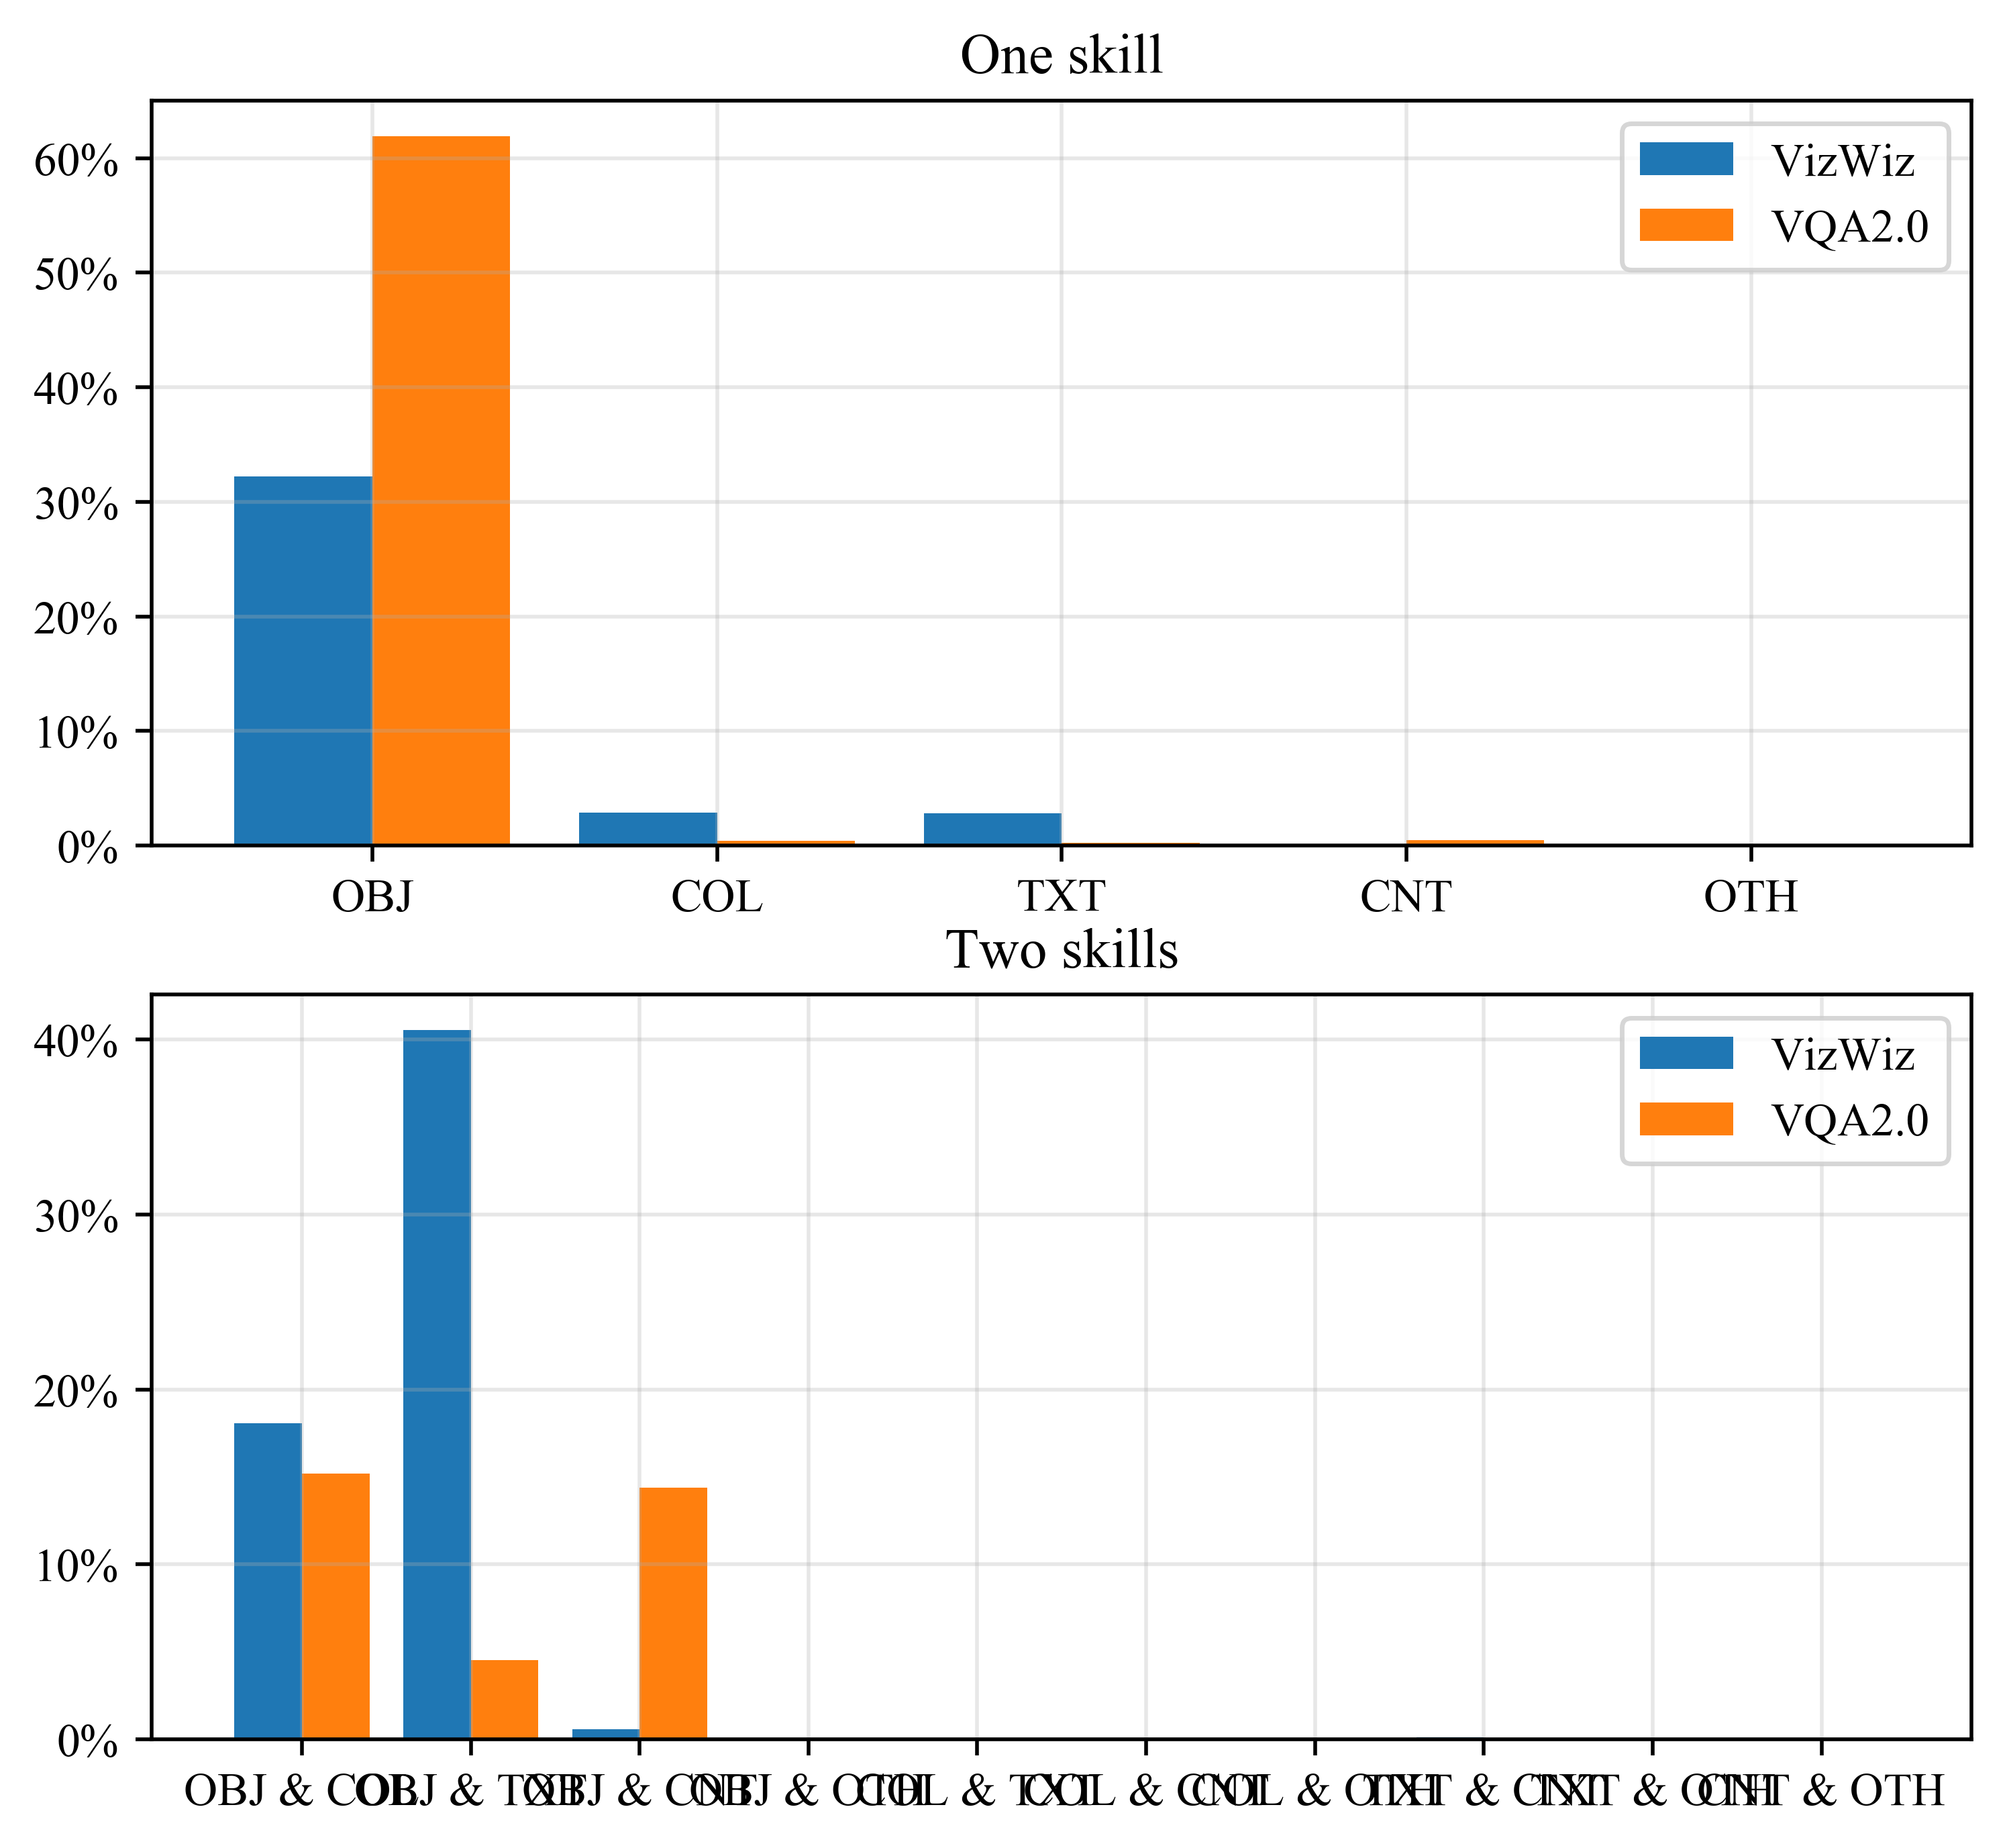

In [11]:
# distribution of skill combinations

# metadata - https://chi2018.acm.org/wp-content/uploads/2017/04/SIGCHIPaperFormat.pdf
fig = figure(num=None, figsize=(7, 10), dpi=500)
w = 0.4
itv = 0.2

# one skill
skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
_one_skill = np.arange(len(skills))
dset = vizwiz
vizwiz_data = [one_skill(dset, 'OBJ'), one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH') ]
dset = vqa
vqa_data = [one_skill(dset, 'OBJ'), one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH') ]

one_skill_plot = fig.add_subplot(3,1,1)
one_skill_plot.grid(alpha=.3)
one_skill_plot.bar(_one_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz')
one_skill_plot.bar(_one_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0')
one_skill_plot.set_xticks(_one_skill)
one_skill_plot.set_xticklabels(skills)

one_skill_plot_y_ticks = one_skill_plot.get_yticks()
one_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in one_skill_plot_y_ticks])
one_skill_plot.set_title('One skill')
one_skill_plot.legend()

# two skills
two_skill_combinations = ['OBJ & COL', 'OBJ & TXT', 'OBJ & CNT', 'OBJ & OTH',
             'COL & TXT', 'COL & CNT', 'COL & OTH', 'TXT & CNT', 'TXT & OTH', 'CNT & OTH']
_two_skill = np.arange(len(two_skill_combinations))
dset = vizwiz
vizwiz_data = [two_skills(dset, 'OBJ', 'COL'), two_skills(dset, 'OBJ', 'TXT'), 
               two_skills(dset, 'OBJ', 'CNT'), two_skills(dset, 'OBJ', 'OTH'),
               two_skills(dset, 'COL', 'TXT'), two_skills(dset, 'COL', 'CNT'),
               two_skills(dset, 'COL', 'OTH'), two_skills(dset, 'TXT', 'CNT'),
               two_skills(dset, 'TXT', 'OTH'), two_skills(dset, 'CNT', 'OTH')]
dset = vqa
vqa_data = [two_skills(dset, 'OBJ', 'COL'), two_skills(dset, 'OBJ', 'TXT'), 
               two_skills(dset, 'OBJ', 'CNT'), two_skills(dset, 'OBJ', 'OTH'),
               two_skills(dset, 'COL', 'TXT'), two_skills(dset, 'COL', 'CNT'),
               two_skills(dset, 'COL', 'OTH'), two_skills(dset, 'TXT', 'CNT'),
               two_skills(dset, 'TXT', 'OTH'), two_skills(dset, 'CNT', 'OTH')]
two_skill_plot = fig.add_subplot(3,1,2, sharex=None)
two_skill_plot.grid(alpha=.3)
two_skill_plot.bar(_two_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz')
two_skill_plot.bar(_two_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0')
two_skill_plot.set_xticklabels(two_skill_combinations)
two_skill_plot.set_xticks(_two_skill)
two_skill_plot_y_ticks = two_skill_plot.get_yticks()
two_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in two_skill_plot_y_ticks])
two_skill_plot.set_title('Two skills')
two_skill_plot.legend()

# three_skill_plot = fig.add_subplot(3,1,3)

plt.show()

In [6]:
len(vizwiz_data)

5

OBJ: 0.32246018176909924
COL: 0.028435166021776297
TXT: 0.02830018896787546
CNT: 0.0002699541078016737
OTH: 0.0


ValueError: shape mismatch: objects cannot be broadcast to a single shape

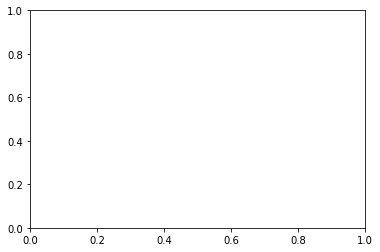

In [32]:
# distributions of skill combinations

dset = vizwiz
one_skill_comb = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
two_skill_comb = []

skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH',
         'OBJ & COL', 'OBJ & TXT', 'OBJ & CNT', 'OBJ & OTH',
         'COL & TXT', 'COL & CNT', 'COL & OTH',
         'TXT & CNT', 'TXT & OTH',
         'OBJ & COL & TXT', 'OBJ & COL & OTH'
         'OBJ & TXT & CNT', 'OBJ & TXT & OTH', 
         'OBJ & COL & TXT & OTH']

data = [one_skill(dset, 'OBJ'), one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH') ]

y_pos = np.arange(len(skills))
plt.bar(y_pos, data)
plt.xticks(y_pos, skills)

In [83]:
"""
one_skill(dset, 'OBJ')
one_skill(dset, 'COL')
one_skill(dset, 'TXT')
one_skill(dset, 'CNT')
one_skill(dset, 'OTH')
"""

"\none_skill(dset, 'OBJ')\none_skill(dset, 'COL')\none_skill(dset, 'TXT')\none_skill(dset, 'CNT')\none_skill(dset, 'OTH')\n"

In [ ]:
vizwiz_train_questions = vizwiz_train['QID'].unique()
vqa_train_questions = vqa_train['QID'].unique()

vizwiz_val_questions = vizwiz_val['QID'].unique()
vqa_val_questions = vqa_val['QID'].unique()

vizwiz_test_questions = vizwiz_test['QID'].unique()
vqa_test_questions = vqa_test['QID'].unique()